# <center>Statoil Kaggle competition (data preparation)</center>

### Link
https://www.kaggle.com/c/statoil-iceberg-classifier-challenge/

### Description
Drifting icebergs present threats to navigation and activities in areas such as offshore of the East Coast of Canada.

Currently, many institutions and companies use aerial reconnaissance and shore-based support to monitor environmental conditions and assess risks from icebergs. However, in remote areas with particularly harsh weather, these methods are not feasible, and the only viable monitoring option is via satellite.

Statoil, an international energy company operating worldwide, has worked closely with companies like C-CORE. C-CORE have been using satellite data for over 30 years and have built a computer vision based surveillance system. To keep operations safe and efficient, Statoil is interested in getting a fresh new perspective on how to use machine learning to more accurately detect and discriminate against threatening icebergs as early as possible.

In this competition, you’re challenged to build an algorithm that automatically identifies if a remotely sensed target is a ship or iceberg. Improvements made will help drive the costs down for maintaining safe working conditions.

### Motivation

2 years ago I participated in this competition and finished at 1838th place out of 3341 (top 56%). My result was 0.21476 (**Logloss** metric). Two years later I decided to try latest Deep Learning models to improve my score.

In [1]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

%matplotlib inline

### Data investigation (train dataset)

In [2]:
train = pd.read_json('train.json')
print(train.shape)
train.head(3)

(1604, 5)


,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1


In [9]:
# Plot images in both bands

def plot_samples(is_iceberg=True):
    # select 2 images with icebergs or ships
    i, j = np.random.choice(np.where(train.is_iceberg == int(is_iceberg))[0], size=2, replace=False)
    
    figsize(12, 8)
    fig = plt.figure()
    
    ax1 = fig.add_subplot(221)
    sns.heatmap(np.array(train.band_1.values[i]).reshape(75, 75), cmap='cubehelix', ax=ax1)
    ax1.set_title('band_1')
    ax1.axis('off')

    ax2 = fig.add_subplot(222)
    sns.heatmap(np.array(train.band_2.values[i]).reshape(75, 75), cmap='cubehelix', ax=ax2)
    ax2.set_title('band_2')
    ax2.axis('off')
    
    ax3 = fig.add_subplot(223)
    sns.heatmap(np.array(train.band_1.values[j]).reshape(75, 75), cmap='cubehelix', ax=ax3)
    ax3.set_title('band_1')
    ax3.axis('off')

    ax4 = fig.add_subplot(224)
    sns.heatmap(np.array(train.band_2.values[j]).reshape(75, 75), cmap='cubehelix', ax=ax4)
    ax4.set_title('band_2')
    ax4.axis('off')

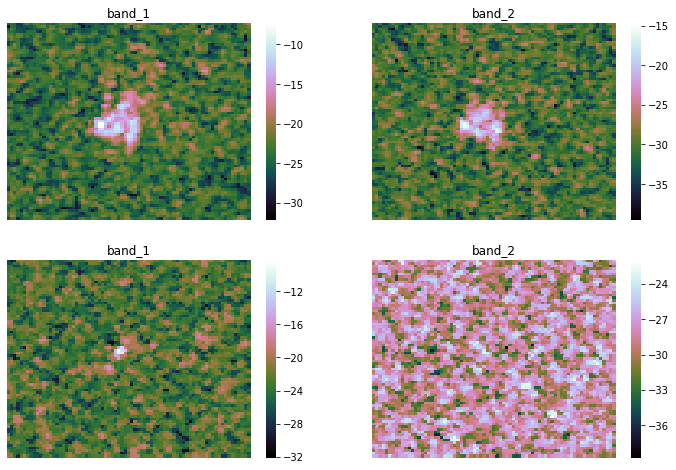

In [10]:
# 2 icebergs
plot_samples(True)

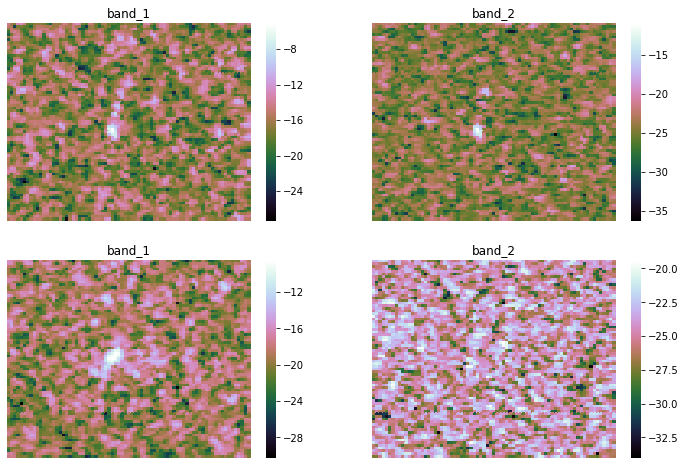

In [11]:
# 2 ships
plot_samples(False)

In [12]:
# distribution of target

train.is_iceberg.value_counts()

0    851
1    753
Name: is_iceberg, dtype: int64

Number of na: 133


(32, 32.5)

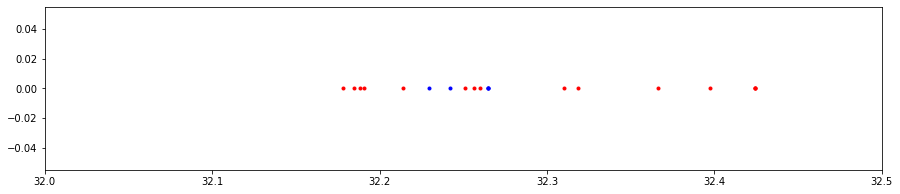

In [13]:
# inc_angle

print('Number of na:', train[train.inc_angle=='na'].shape[0])

temp = train[(train.inc_angle!='na')]

figsize(15, 3)
plt.plot(temp[temp.is_iceberg==0].inc_angle.values, np.zeros(temp[temp.is_iceberg==0].shape[0]), 'r.')
plt.plot(temp[temp.is_iceberg==1].inc_angle.values, np.zeros(temp[temp.is_iceberg==1].shape[0]), 'b.')

plt.xlim([32, 32.5])

In [14]:
# It seems that icebergs and ships contain groups in inc_angle feature.
# (this was mentioned in many solutions for this Kaggle competition)

### KNeighborsClassifier on inc_angle feature

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

X_train = train.loc[train.inc_angle!='na', ['inc_angle']]
y_train = train.loc[train.inc_angle!='na', ['is_iceberg']]

gscv = GridSearchCV(KNeighborsClassifier(),
                    param_grid={'n_neighbors':[3, 5, 6, 7, 8, 9, 10],
                                'weights': ['uniform', 'distance'],
                                'metric':['manhattan']},
                    scoring='accuracy',
                    cv=5,
                    n_jobs=-1,
                    verbose=1).fit(X_train, y_train)

print('Best paarmeters:', gscv.best_params_)
print('Best accuracy:', gscv.best_score_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best paarmeters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best accuracy: 0.9170632222977566


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:    2.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    2.1s finished
/home/sergei/Programms/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


### Improve signal-noice ratio of images

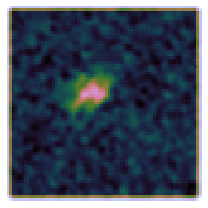

In [16]:
from scipy.signal import convolve2d

i = 6

# create numpy array from data
img = np.array(train.band_2.values[5]).reshape(75, 75)

# convolve with square kernel
kernel = np.ones([3, 3]) / 9.
img = convolve2d(img, kernel, mode='full')

figsize(3, 3)
fig = plt.figure()
ax = fig.add_subplot(111)
sns.heatmap(img, cmap='cubehelix', cbar=False, square=True, ax=ax)
plt.axis('off')
fig.tight_layout()
fig.savefig('test_{}_{}.jpg'.format(train.is_iceberg.values[i], train.id.values[i]),
            pad_inches=0, quality=100, bbox_inches='tight', dpi=20)

In [17]:
# Check image size

from PIL import Image

pic = Image.open('test_0_9d8f326c.jpg')
pix = np.array(pic)
pix.shape

(74, 74, 3)

### Prepare images of band_1 and band_2 from train dataset 

In [18]:
from scipy.signal import convolve2d
from tqdm import tqdm

def band_to_image(df, is_train=True, band_name='band_1', folder_name='train'):
    # convolution kernel
    kernel = np.ones([3, 3]) / 9.
    
    for i in tqdm(range(df.shape[0])):
        # reshape values to 2D
        img = np.array(df[band_name].values[i]).reshape(75, 75)
        # smoothing using convolution
        img = convolve2d(img, kernel, mode='full')
        
        # filename
        if is_train:
            fname = '{}/{}/{}_{}.jpg'.format(folder_name, band_name, df.is_iceberg.values[i], df.id.values[i])
        else:
            fname = '{}/{}/{}.jpg'.format(folder_name, band_name, df.id.values[i])

        fig = plt.figure()
        ax = fig.add_subplot(111)
        # create a figure using seaborn
        sns.heatmap(img, cmap='cubehelix', cbar=False, square=True, ax=ax)
        # remove axis
        plt.axis('off')
        # remove layout
        fig.tight_layout()
        fig.savefig(fname, pad_inches=0, quality=100, bbox_inches='tight', dpi=20)

In [19]:
!mkdir train
!mkdir train/band_1
!mkdir train/band_2

In [20]:
band_to_image(train, is_train=True, band_name='band_1', folder_name='train')

In [21]:
band_to_image(train, is_train=True, band_name='band_2', folder_name='train')

### Explore test dataset

In [22]:
test = pd.read_json('test.json')
print(test.shape)
test.head()

(8424, 4)


,id,band_1,band_2,inc_angle
0,5941774d,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",34.966400
1,4023181e,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",32.615072
2,b20200e4,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",37.505433
3,e7f018bb,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",34.473900
4,4371c8c3,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",43.918874


Text(0.5, 1.0, 'test')

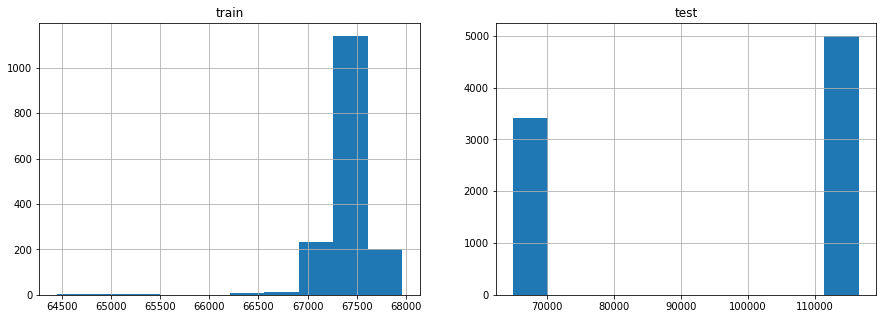

In [23]:
figsize(15, 5)
fig = plt.figure()

ax1 = fig.add_subplot(121)
train.band_1.apply(lambda x: len(str(x))).hist(ax=ax1)
ax1.set_title('train')

ax2 = fig.add_subplot(122)
test.band_1.apply(lambda x: len(str(x))).hist(ax=ax2)
ax2.set_title('test')

In [24]:
# It's clear that there are 5000 machine generated images in the test dataset (as mentioned in the description)
# These images will not be counted, so we can easily remove them by threshold.

In [25]:
test = (test
        .assign(is_real = lambda x: [len(str(y)) for y in x.band_1.values])
        .loc[lambda x: x.is_real < 80000, ['id', 'band_1', 'band_2', 'inc_angle']]
       )
print(test.shape)
test.head(3)

(3424, 4)


,id,band_1,band_2,inc_angle
0,5941774d,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",34.9664
3,e7f018bb,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",34.4739
6,29e7727e,"[-24.565174, -26.567524, -25.946882, -26.89542...","[-32.915886, -35.194798, -32.272282, -28.7505,...",42.4142


In [26]:
test.to_json('test_real.json')
test.shape

### Prepare images of band_1 and band_2 from test_real dataset 

In [27]:
!mkdir test
!mkdir test/band_1
!mkdir test/band_2

In [28]:
band_to_image(test, is_train=False, band_name='band_1', folder_name='test')

In [29]:
band_to_image(test, is_train=False, band_name='band_2', folder_name='test')